# Practical exercise 8 - Methods 3, 2021.
Aleksander Moeslund Wael

### Importing packages


In [12]:
from matplotlib.colors import Colormap
import numpy as np
import matplotlib.pyplot as plt

# EXERCISE 1 - Load the magnetoencephalographic recordings and do some initial plots to understand the data

### 1) Load `megmag_data.npy` and call it `data` using `np.load`. You can use `join`, which can be imported from `os.path`, to create paths from different string segments


In [13]:
data = np.load("megmag_data.npy")

i. The data is a 3-dimensional array. The first dimension is number of repetitions of a visual stimulus , the second dimension is the number of sensors that record magnetic fields (in Tesla) that stem from neurons activating in the brain, and the third dimension is the number of time samples. How many repetitions, sensors and time samples are there?

In [14]:
data.shape

(682, 102, 251)

There are 682 repetitions, 102 sensors and 251 time samples.

ii. The time range is from (and including) -200 ms to (and including) 800 ms with a sample recorded every 4 ms. At time 0, the visual stimulus was briefly presented. Create a 1-dimensional array called `times` that represents this.  
    


In [15]:
times = np.arange(-200, 804, 4)

iii. Create the sensor covariance matrix $\Sigma_{XX}$: $$\Sigma_{XX} = \frac 1 N \sum_{i=1}^N XX^T$$ $N$ is the number of repetitions and $X$ has $s$ rows and $t$ columns (sensors and time), thus the shape is $X_{s\times t}$. Do the sensors pick up independent signals? (Use `plt.imshow` to plot the sensor covariance matrix)  


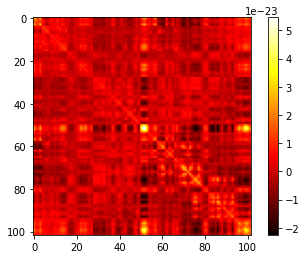

In [16]:
covar = np.zeros(shape = (102,102))

for i in range(682):
    X = data[i]
    covar = covar + X @ np.transpose(X)

covar = (1/682)*covar

plt.close("all")
plt.figure()
plt.imshow(covar, cmap = "hot")
plt.colorbar()
plt.show()

iv. Make an average over the repetition dimension using `np.mean` - use the `axis` argument. (The resulting array should have two dimensions ~~with time as the first and magnetic field as the second~~ with sensor as the first and time as the second)  


In [17]:
datamean = data.mean(axis=0)
datamean.shape

(102, 251)

v. Plot the magnetic field (based on the average) as it evolves over time for each of the sensors (a line for each) (time on the x-axis and magnetic field on the y-axis). Add a horizontal line at $y = 0$ and a vertical line at $x = 0$ using `plt.axvline` and `plt.axhline`  


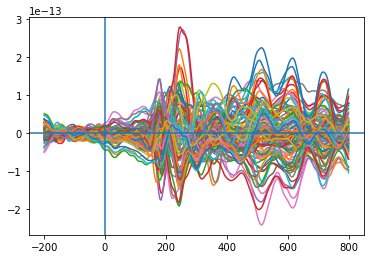

In [18]:
plt.close("all")
plt.figure()
plt.plot(times, datamean.T)
plt.axvline()
plt.axhline()
plt.show()

vi. Find the maximal magnetic field in the average. Then use `np.argmax` and `np.unravel_index` to find the sensor that has the maximal magnetic field.  


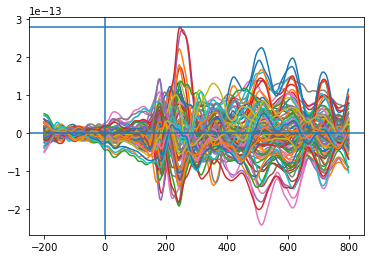

18435
(73, 112)


In [19]:
sensor_max = np.amax(datamean)

plt.close("all")
plt.figure()
plt.plot(times, datamean.T)
plt.axvline()
plt.axhline()
plt.axhline(np.amax(datamean))
plt.show()

np.argmax(datamean) # finding the index (think: coordinates) for the biggest value
print(np.argmax(datamean))

a = np.unravel_index(np.argmax(datamean), shape = (102, 251)) # shape = the space where it searches for the index
print(a) # The sensor with max magnetic value is no. 73

 vii. Plot the magnetic field for each of the repetitions (a line for each) for the sensor that has the maximal magnetic field. Highlight the time point with the maximal magnetic field in the average (as found in 1.1.v) using `plt.axvline`  


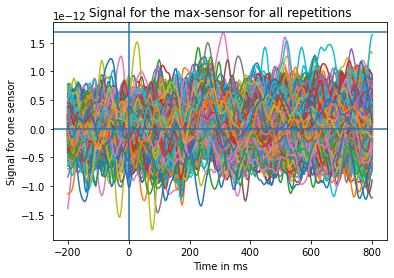

In [20]:
plt.figure() 
plt.plot(times, data[:,73,:].T)
plt.axhline(np.amax(data[:,73,:].T))
plt.axvline(x = 0)
plt.axhline(y = 0)
plt.xlabel("Time in ms")
plt.ylabel("Signal for one sensor")
plt.title("Signal for the max-sensor for all repetitions")
plt.show()

viii. Describe in your own words how the response found in the average is represented in the single repetitions. But do make sure to use the concepts _signal_ and _noise_ and comment on any differences on the range of values on the y-axis  

EXPLAIN


### 2) Now load `pas_vector.npy` (call it `y`). PAS is the same as in Assignment 2, describing the clarity of the subjective experience the subject reported after seeing the briefly presented stimulus


In [21]:
y = np.load("pas_vector.npy")

i. Which dimension in the `data` array does it have the same length as?  


It has the same length as repetitions, because there is a PAS rating per repitition.

ii. Now make four averages (As in Exercise 1.1.iii), one for each PAS rating, and plot the four time courses (one for each PAS rating) for the sensor found in Exercise ~~1.1.v~~  1.1.vi


In [22]:
# subsetting the data, so I'm only looking at sensor 73 
data_1_2 = data[:, 73, :]

# in y I find the indices for each different pas rating and assign them to new lists
pas_1 = np.where(y == 1)
pas_2 = np.where(y == 2)
pas_3 = np.where(y == 3)
pas_4 = np.where(y == 4)

# finding the average brain activation in sensor 73 seperated by pas-rating
sens_73_pas1_avg = np.mean(data_73[pas_1], axis = 0)
sens_73_pas2_avg = np.mean(data_73[pas_2], axis = 0)
sens_73_pas3_avg = np.mean(data_73[pas_3], axis = 0)
sens_73_pas4_avg = np.mean(data_73[pas_4], axis = 0)

# plotting this baby
plt.figure
plt.plot(times, sens_73_pas1_avg)
plt.plot(times, sens_73_pas2_avg)
plt.plot(times, sens_73_pas3_avg)
plt.plot(times, sens_73_pas4_avg)
plt.axvline()
plt.axhline()
plt.xlabel(" time")
plt.ylabel("magnetic field")
plt.title("Average magnetic field for each PAS-rating (sensor 73)")
plt.legend(["pas 1", "pas 2", "pas 3", "pas 4"])
plt.show

NameError: name 'data_73' is not defined

iii. Notice that there are two early peaks (measuring visual activity from the brain), one before 200 ms and one around 250 ms. Describe how the amplitudes of responses are related to the four PAS-scores. Does PAS 2 behave differently than expected?  

EXPLAIN

# EXERCISE 2 - Do logistic regression to classify pairs of PAS-ratings

### 1) Now, we are going to do Logistic Regression with the aim of classifying the PAS-rating given by the subject

i. We'll start with a binary problem - create a new array called `data_1_2` that only contains PAS responses 1 and 2. Similarly, create a `y_1_2` for the target vector

In [ ]:
data_1_2 = np.concatenate((data[pas_1], data[pas_2]), axis=0)
data_1_2.shape

y_1_2 = []
for i in range(len(y)):
    if y[i] == 1:
        y_1_2.append(1)
    if y[i] == 2:
        y_1_2.append(2)

ii. Scikit-learn expects our observations (`data_1_2`) to be in a 2d-array, which has samples (repetitions) on dimension 1 and features (predictor variables) on dimension 2. Our `data_1_2` is a three-dimensional array. Our strategy will be to collapse our two last dimensions (sensors and time) into one dimension, while keeping the first dimension as it is (repetitions). Use `np.reshape` to create a variable `X_1_2` that fulfils these criteria.

In [ ]:
# repetition as rows, and sensor and time as columns
X_1_2 = data_1_2.reshape(214, -1)
X_1_2.shape

iii. Import the `StandardScaler` and scale `X_1_2`  


In [ ]:
from sklearn.preprocessing import StandardScaler # package to standardize values in df

sc = StandardScaler()
X_1_2_scaled = sc.fit_transform(X_1_2)

iv. Do a standard `LogisticRegression` - can be imported from `sklearn.linear_model` - make sure there is no `penalty` applied

In [ ]:
from sklearn.linear_model import LogisticRegression

logR = LogisticRegression(penalty='none') # no regularisation

logR.fit(X_1_2_scaled, y_1_2)

v. Use the `score` method of `LogisticRegression` to find out how many labels were classified correctly. Are we overfitting? Besides the score, what would make you suspect that we are overfitting?  

In [ ]:
print(logR.score(X_1_2_scaled, y_1_2))

vi. Now apply the _L1_ penalty instead - how many of the coefficients (`.coef_`) are non-zero after this?  

In [ ]:
logR = LogisticRegression(penalty="l1", solver='liblinear', random_state=1) # With regularization
logR.fit(X_1_2_scaled, y_1_2)
print(logR.score(X_1_2_scaled, y_1_2))

fit1 = logR.fit(X_1_2_scaled, y_1_2)

print(np.sum(fit1.coef_ == 0))
print(np.sum(fit1.coef_ != 0)) # = 217 coefs were nonzero

vii. Create a new reduced $X$ that only includes the non-zero coefficients - show the covariance of the non-zero features (two covariance matrices can be made; $X_{reduced}X_{reduced}^T$ or $X_{reduced}^TX_{reduced}$ (you choose the right one)) . Plot the covariance of the features using `plt.imshow`. Compared to the plot from 1.1.iii, do we see less covariance?

In [ ]:
coefs = logR.coef_.flatten()
non_zero = coefs != 0
X_reduced = X_1_2_scaled[:, non_zero]

# Non-zero coefficients covariance matrix
coef_covar = np.zeros(shape = (217,217))

for i in range(217):
    X = X_reduced[i]
    covar = covar + X @ np.transpose(X)

coef_covar = (1/682)*coef_covar

plt.close("all")
plt.figure()
plt.imshow(covar, cmap = "hot")
plt.colorbar()
plt.show()

### 2) Now, we are going to build better (more predictive) models by using cross-validation as an outcome measure

i. Import `cross_val_score` and `StratifiedKFold` from `sklearn.model_selection`

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

ii. To make sure that our training data sets are not biased to one target (PAS) or the other, create `y_1_2_equal`, which should have an equal number of each target. Create a similar `X_1_2_equal`. The function `equalize_targets_binary` in the code chunk associated with Exercise 2.2.ii can be used. Remember to scale `X_1_2_equal`!

In [ ]:
def equalize_targets_binary(data, y):
    np.random.seed(7)
    targets = np.unique(y) ## find the number of targets
    if len(targets) > 2:
        raise NameError("can't have more than two targets")
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target)) ## find the number of each target
        indices.append(np.where(y == target)[0]) ## find their indices
    min_count = np.min(counts)
    # randomly choose trials
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count,replace=False)
    
    # create the new data sets
    new_indices = np.concatenate((first_choice, second_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

# Making equal data with function
y_1_2 = np.array(y_1_2) # Has to be array instead of list, thats why
data_1_2_equal, y_1_2_equal = equalize_targets_binary(data_1_2, y_1_2) # Assigning new data
X_1_2_equal = data_1_2_equal.reshape(198, -1)
X_1_2_equal = sc.fit_transform(X_1_2_equal)

iii. Do cross-validation with 5 stratified folds doing standard `LogisticRegression` (See Exercise 2.1.iv)

In [ ]:
cv = StratifiedKFold()

logR = LogisticRegression()
logR.fit(X_1_2_equal, y_1_2_equal)

scores = cross_val_score(logR, X_1_2_equal, y_1_2_equal, cv=5)
print(np.mean(scores))

iv. Do L2-regularisation with the following `Cs=  [1e5, 1e1, 1e-5]`. Use the same kind of cross-validation as in Exercise 2.2.iii. In the best-scoring of these models, how many more/fewer predictions are correct (on average)?

In [ ]:
# With C = 1e5
cv = StratifiedKFold()

logR = LogisticRegression(C=1e5, penalty="l2")
logR.fit(X_1_2_equal, y_1_2_equal)

scores = cross_val_score(logR, X_1_2_equal, y_1_2_equal, cv=5)
print(np.mean(scores))

# With C = 1e1
cv = StratifiedKFold()

logR = LogisticRegression(C=1e1, penalty="l2")
logR.fit(X_1_2_equal, y_1_2_equal)

scores = cross_val_score(logR, X_1_2_equal, y_1_2_equal, cv=5)
print(np.mean(scores))

# With C = 1e-1
cv = StratifiedKFold()

logR = LogisticRegression(C=1e-5, penalty="l2")
logR.fit(X_1_2_equal, y_1_2_equal)

logR.predict

scores = cross_val_score(logR, X_1_2_equal, y_1_2_equal, cv=5)
print(np.mean(scores))

v. Instead of fitting a model on all `n_sensors * n_samples` features, fit  a logistic regression (same kind as in Exercise 2.2.iv (use the `C` that resulted in the best prediction)) for __each__ time sample and use the same cross-validation as in Exercise 2.2.iii. What are the time points where classification is best? Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)

In [ ]:
# I need 251 models.
cv = StratifiedKFold()
logR = LogisticRegression(C=1e1, penalty="l2", solver = "liblinear")
cv_scores = []

# Subsetting time
for i in range(251):
    t = sc.fit_transform(data_1_2_equal[:,:,i])
    logR.fit(t, y_1_2_equal)
    scores = cross_val_score(logR, t, y_1_2_equal, cv=5)
    cv_scores.append(np.mean(scores))

In [ ]:
# Picking highest score
np.amax(cv_scores)
np.argmax(cv_scores) # Indeci with highest classification

In [ ]:
plt.figure() 
plt.plot(times, cv_scores)
plt.axvline(x = 0)
plt.axvline(times[94])
plt.axhline(y = 0.5) # Chance level is 50% for binary classification
plt.xlabel("Time in ms")
plt.ylabel("Classification score")
plt.title("Classification scores at given times")
plt.show()

times[94]

# Classification is best at 176 ms.

vi. Now do the same, but with L1 regression - set `C=1e-1` - what are the time points when classification is best? (make a plot)?

In [ ]:
cv = StratifiedKFold()
logR = LogisticRegression(C=1e-1, penalty="l1", solver = "liblinear")
cv_scores = []

# Subsetting time
for i in range(251):
    t = sc.fit_transform(data_1_2_equal[:,:,i])
    logR.fit(t, y_1_2_equal)
    scores = cross_val_score(logR, t, y_1_2_equal, cv=5)
    cv_scores.append(np.mean(scores))


In [ ]:
# Picking highest score
np.amax(cv_scores)
np.argmax(cv_scores) # Indeci with highest classification

In [ ]:
plt.figure() 
plt.plot(times, cv_scores)
plt.axvline(x = 0)
plt.axvline(times[36])
plt.axhline(y = 0.5) # Chance level is 50% for binary classification
plt.xlabel("Time in ms")
plt.ylabel("Classification score")
plt.title("Classification scores at given times")
plt.show()

times[36]

# Classification is best at -56 ms.

vii. Finally, fit the same models as in Exercise 2.2.vi but now for `data_1_4` and `y_1_4` (create a data set and a target vector that only contains PAS responses 1 and 4). What are the time points when classification is best? Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)

### 3) Is pairwise classification of subjective experience possible? Any surprises in the classification accuracies, i.e. how does the classification score fore PAS 1 vs 4 compare to the classification score for PAS 1 vs 2?  